In [1]:
import os, sys
from tqdm import tqdm
import seaborn as sns
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules.preprocessing import *
from modules.io import *
from modules.learning import *
from modules.patterns import *
from modules.statistics import *
from modules.plots import *
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import normalize
import seaborn
import pickle
from tqdm.notebook import tqdm
plt.style.use('ggplot')

# Detect with static yaw with a different approach (regression that fits best)

# Load Data

In [2]:
dataset_file = '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet'
df = load_df(dataset_file)
df = df.dropna(axis=1, how='all')
df.columns = df.columns.str.replace('cor. ', '', regex=False)

In [3]:
cols = ['wind speed', 'pitch angle', 'rotor speed', 'active power',
        'nacelle direction', 'wind direction']
df = df[cols]

# Resample and apply filters

In [4]:
df.head()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction
datetime,,,,,,
2018-01-02 00:00:00,10.702713,1.280000,15.196488,2076.853516,221.656799,225.582748
2018-01-02 00:00:02,10.678821,4.425176,15.191995,2098.739014,221.656799,225.038376
2018-01-02 00:00:04,12.006075,5.560401,15.187502,2107.982861,221.656799,226.060517
2018-01-02 00:00:06,12.548021,5.909353,15.183009,2111.757324,221.656799,221.221125
2018-01-02 00:00:08,11.670061,5.831193,15.178516,2054.391846,221.656799,212.979418


In [5]:
def outliers_IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_iqr = df[~((df < (Q1 - 1.5 * IQR)) | (df >(Q3 + 1.5 * IQR))).any(axis=1)]
    return df_iqr

# Resample with 60second granularity
df=change_granularity(df,granularity='1min')

df["theta_d"] = (df['wind direction'] - df['nacelle direction']) % 360
df["theta_d"][df["theta_d"] > +180] -= 360
df["theta_d"][df["theta_d"] < -180] += 360
df["theta_d"] = df["theta_d"].rolling(60).mean()
df = df.dropna()

df_initial = df.copy()

# Perform IQR outlier removal
df = outliers_IQR(df)
print(df.shape)

# drop values of wind speed under 5m/s
df=filter_col(df, 0, less_than=5, bigger_than=11)

# drop values with pitch angle higher than 2 degrees or lower than -2 degrees
df=filter_col(df, 1, less_than=-2, bigger_than=2)

# drop values of rotor speed under 8rpm
df=filter_col(df, 2, less_than=8, bigger_than=15)

# drop values of power near the power_limit and near or below zero
power_limit = 2050
df=filter_col(df, 4, less_than=1e-4, bigger_than= None)



#filter dynamic yaw
#df=filter_col(df, -1, less_than=-1, bigger_than= 1)

# Keep only dates with lidar measurements
start = '2018-06-02'
end = '2019-01-11'
df = filter_dates(df, start, end)
print(df.info())

Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete
(419094, 7)
Filter Complete
Filter Complete
Filter Complete
Filter Complete
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127875 entries, 2018-06-02 00:00:00 to 2019-01-10 23:41:00
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   wind speed         127875 non-null  float64
 1   pitch angle        127875 non-null  float64
 2   rotor speed        127875 non-null  float64
 3   active power       127875 non-null  float64
 4   nacelle direction  127875 non-null  float64
 5   wind direction     127875 non-null  float64
 6   theta_d            127875 non-null  float64
dtypes: float64(7)
memory usage: 7.8 MB
None


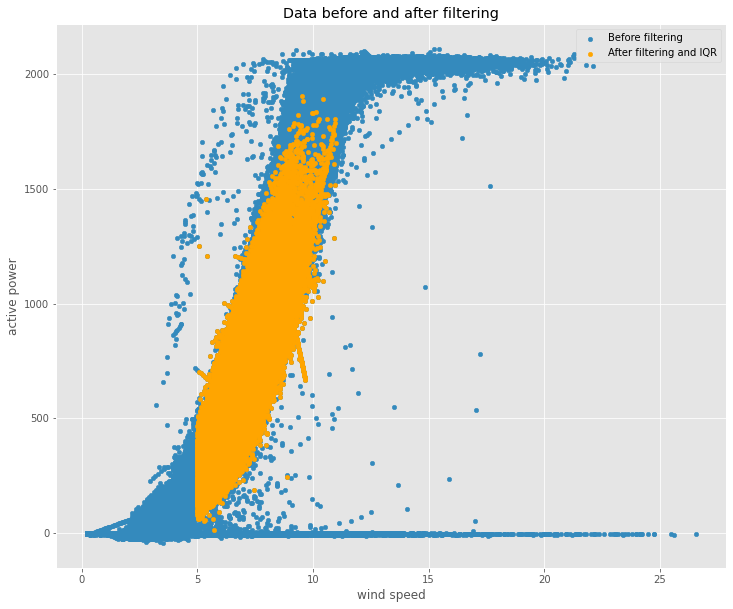

In [6]:
ax1=df_initial.plot.scatter(x='wind speed', y='active power', figsize=(12, 10), label='Before filtering')
df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='orange', label = 'After filtering and IQR')
plt.title("Data before and after filtering")
plt.show()

# Print statistics

In [7]:
df.describe()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction,theta_d
count,127875.000000,127875.000000,127875.000000,127875.000000,127875.000000,127875.000000,127875.000000
mean,6.607925,0.018315,11.656489,571.277060,198.755939,197.678923,-0.770615
std,1.134229,0.099704,1.872382,318.096729,89.724844,86.798095,5.716963
min,5.000017,0.000000,8.060883,13.902413,1.009572,1.710276,-17.900762
25%,5.675842,0.000000,10.121951,311.394795,145.376487,142.066856,-4.002664
50%,6.430575,0.000000,11.535931,496.874924,196.413910,196.215395,-0.552188
75%,7.350391,0.000000,13.233398,781.736093,266.657501,262.363894,2.567352
max,10.985393,1.998431,14.999840,1903.292636,359.951050,359.377923,16.575559


# Print correlations

In [8]:
df.corr()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction,theta_d
wind speed,1.000000,0.311280,0.844279,0.851771,-0.124221,-0.127154,-0.059645
pitch angle,0.311280,1.000000,0.206509,0.344701,-0.035046,-0.042572,-0.119307
rotor speed,0.844279,0.206509,1.000000,0.962786,-0.176769,-0.177683,-0.026448
active power,0.851771,0.344701,0.962786,1.000000,-0.184335,-0.188848,-0.055845
nacelle direction,-0.124221,-0.035046,-0.176769,-0.184335,1.000000,0.945674,-0.193891
wind direction,-0.127154,-0.042572,-0.177683,-0.188848,0.945674,1.000000,-0.144785
theta_d,-0.059645,-0.119307,-0.026448,-0.055845,-0.193891,-0.144785,1.000000


# Remove outliers using the iQR method and Local Outlier Factor

In [9]:
def outliers_LoF(df):
    clf = LocalOutlierFactor(n_neighbors=300, n_jobs=16)
    res = clf.fit_predict(df)
    df = df[res == 1]
    return df


In [10]:
df_outliers = df.copy()
df = outliers_LoF(df).copy()
print(df.shape)

(125702, 7)


In [11]:
# TODO filtering and iqr fix

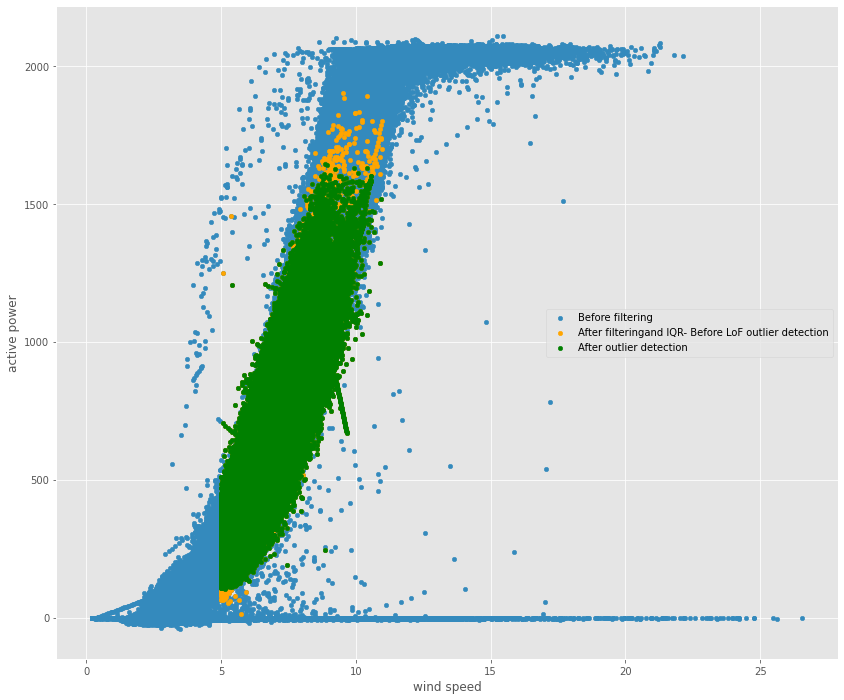

In [12]:
ax1 = df_initial.plot.scatter(x='wind speed', y='active power', figsize=(14, 12), label='Before filtering')
ax1 = df_outliers.plot.scatter(ax =ax1, x='wind speed', y='active power', c='orange', figsize=(14, 12), label='After filteringand IQR- Before LoF outlier detection')
df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='green', label = 'After outlier detection')
plt.show()

# Add a column with the measured static yaw misalignment

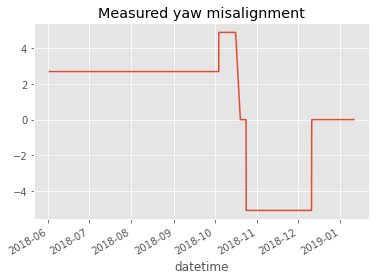

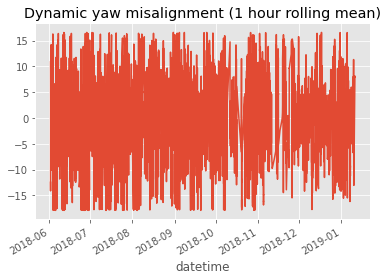

In [13]:
df["y"] = np.nan
m1 = (df.index >= '2018-10-17') & (df.index < '2018-10-24')
m2 = (df.index >= '2018-12-11')
date_masks = [(df.index < '2018-08-02'),
              (df.index >= '2018-08-02') & (df.index < '2018-10-04'),
              (df.index >= '2018-10-04') & (df.index < '2018-10-17'),
              (df.index >= '2018-10-17') & (df.index < '2018-10-24'),
              (df.index >= '2018-10-24') & (df.index < '2018-12-11'),
              (df.index >= '2018-12-11')]


#static_misalignment_values = [-6.7, 4.8, 9.4, 0, -5.8, 0] # BBZ1

static_misalignment_values = [2.7, 2.7, 4.9, 0, -5.1, 0] # BBZ2

#static_misalignment_values = [-2.2, 3.4, 7.5, 0, -5.5, 0] # BBZ3


for m, s in zip(date_masks, static_misalignment_values):
    df.loc[m, 'y'] = s
df['y'].plot()
plt.title("Measured yaw misalignment")
plt.show()

df['theta_d'].plot()
plt.title("Dynamic yaw misalignment (1 hour rolling mean)")
plt.show()

### Split dataset into bins based on wind speed

In [14]:
bin_size = 0.5
min_speed = 5
max_speed = 11
bins = np.arange(min_speed, max_speed, bin_size)
bins = np.append(bins,max_speed)
print(bins)
bin_masks = []
bin_feature = 'wind speed'
for i in range(len(bins) - 1):
    mask = (df[bin_feature]>= bins[i]) & (df[bin_feature] < bins[i + 1])
    bin_masks.append(mask)

[ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11. ]


# Estimate the yaw angle using a weighted average of the predicted angles

In [15]:
n_most_freq = None # choose how many of the most frequent values will be used in the weighted average None -> use all values

### Wind speed only

[2.7, 2.7, 4.9, 0, 0]


  0%|          | 0/3 [00:00<?, ?it/s]

{'0.0': {'-6.7': 0.22545714431282138, '0.0': 0.11201864178292874, '4.8': 0.24009115673150566, '9.4': 0.26616130366223284}, '2.7': {'-6.7': 0.05429110090747741, '0.0': 0.1132540667235011, '4.8': 0.06676273656923748, '9.4': 0.09574431089077998}, '4.9': {'-6.7': 0.04562598533812596, '0.0': 0.13134072074304937, '4.8': 0.049349168727621955, '9.4': 0.05871010632675725}}
0.0
For bin 0 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  4.8 6.7] [4000    6   67]

For bin 1 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  6.7] [3549   65]

For bin 2 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  6.7] [3169   30]

For bin 3 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  6.7] [2713   14]

For bin 4 in the regions with ground truth angle 0.0
The distribution of predict

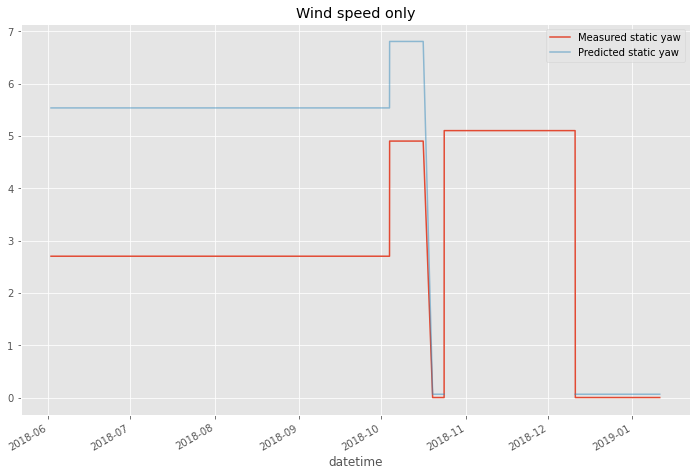

In [16]:
df_scaled = scale_df(df.copy())
df_scaled['y'] = df['y']
selected_features = ['wind speed', 'pitch angle', 'rotor speed']
models_file = 'trained_models_wind_speed.pickle' 
with open(models_file, 'rb') as file:
    models_dict = pickle.load(file)
    
bin_feature = 'wind speed'
binned_data_dfs = []
for b in bin_masks:
    df_temp = df_scaled[b]
    binned_data_dfs.append(df_temp.copy())
    
fit_features = selected_features 
fit_features = ['wind speed']
target_feature = ['active power']
    
evaluation_scores = {}
evaluation_preds = {}
static_misalignment_values1 = [x for i, x in enumerate(static_misalignment_values) if i != 4]
print(static_misalignment_values1)
for theta_s in tqdm(np.unique(static_misalignment_values1)):
    #print(f'Working on {theta_s}')
    evaluation_scores[str(theta_s)] = {}
    evaluation_preds[str(theta_s)] = {}
    for key, models in models_dict.items():
        mape_list = []
        evaluation_preds[str(theta_s)][key] = {}
        #print(f'evaluating with models trained on {key}')
        for bin_n, d in enumerate(binned_data_dfs):
            d = d[d['y'] == theta_s].copy()
            if d.shape[0] >= 100 and models[bin_n] is not None:
                test_preds = predict(d, models[bin_n], fit_features, target_feature)
                r_sq, mae, me, mape, mpe = score(d[target_feature].values, test_preds)
                mape_list.append(mae)
                evaluation_preds[str(theta_s)][key][str(bin_n)] = test_preds
            else:
                evaluation_preds[str(theta_s)][key][str(bin_n)] = None
        avg_mape = np.mean(mape_list)
        evaluation_scores[str(theta_s)][key] = avg_mape
print(evaluation_scores)

# estimate the angle using a weighted average with the frequency of each point
result = {}
for th_s in np.unique(static_misalignment_values1): 
    print(th_s)
    average_for_each_bin = []
    for bin_n, d in enumerate(binned_data_dfs):
        d = d[d['y'] == th_s].copy()
        if d.shape[0] <= 100 or test_preds is None:
            continue
            
        # label each point in one bin to the closest prediction by the models of each angle of the bin
        label_per_bin = np.zeros(d[target_feature].shape) - 1
        diffs_per_bin = np.zeros(d[target_feature].shape) + np.inf # used to hold the minimum diffs until now
        l_test = np.zeros(d[target_feature].shape) - 1
        scoring_metrics = {}
        test_diffs = []
        for key, bin_dict in evaluation_preds[str(th_s)].items():
            # these are the predictions if the trained model corresponding to "key" angle/ in bin bin_n
            test_preds = bin_dict[str(bin_n)]
            if d.shape[0] >= 100 and test_preds is not None:
                # calculate the differences between the actual and predicted values (residuals)
                (r_sq, mae, me, mape, mpe) = score(d[target_feature].values, test_preds)
                temp_diff = np.abs(test_preds-d[target_feature].values)
                test_diffs.append(temp_diff.ravel())
#                 # unncomment line below for histograms of the differences for each bin for each model
#                 plt.hist(temp_diff, label=key, bins = 20)
#                 plt.axvline(temp_diff.mean(), color='k', linestyle='dashed', linewidth=1, label=f'mean of {key} = {temp_diff.mean():.3}')
#                 plt.legend()
#                 plt.show()
                mask = (temp_diff <= diffs_per_bin) # mask to find the points with current difference lower than the minimum
                diffs_per_bin[mask] = temp_diff[mask]
                scoring_metrics[str(np.abs(float(key)))] = (r_sq, mae, me, mape, mpe) # store metrics 
                label_per_bin[mask] = np.abs(float(key)) # assign labels
            else:
                pass
        unique, counts = np.unique(label_per_bin, return_counts=True)
        print(f"For bin {bin_n} in the regions with ground truth angle {th_s}")
        print(f"The distribution of prediction labels for the interval is:")
        print(unique, counts, end='\n\n')
        # barplot  with the frequencies of each label
#         plt.bar(np.arange(unique.shape[0]), counts)
#         plt.xticks(np.arange(unique.shape[0]), labels=unique)
#         plt.show()
        # calculate weighted average for each bin
        if n_most_freq is not None:
            idx = np.argmax(counts)
            unique = unique[idx]
            counts = counts[idx]
        res = np.average(unique, weights=counts)
        average_for_each_bin.append(res)
    print("The weighted average (by frequency) of this bin is:")
    print(average_for_each_bin)
    print(np.mean(average_for_each_bin))
    result[str(th_s)] = np.mean(average_for_each_bin)
    
df['y_pred'] = np.nan
for th_s in np.unique(static_misalignment_values1): 
    df['y_pred'][df['y']==th_s] = result[str(th_s)]
    
prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

target.plot(figsize=(12, 8), label = 'Measured static yaw')
prediction.plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Wind speed only')
plt.legend()
plt.show()







[2.7, 2.7, 4.9, 0, 0]


  0%|          | 0/3 [00:00<?, ?it/s]

{'0.0': {'-6.7': 0.11518869376813082, '0.0': 0.06683681058524692, '4.8': 0.11741557084533233, '9.4': 0.14991166752719443}, '2.7': {'-6.7': 0.03706437084044166, '0.0': 0.039349049998051736, '4.8': 0.04612594490991895, '9.4': 0.04940547934188579}, '4.9': {'-6.7': 0.02628583631008537, '0.0': 0.03128736722414233, '4.8': 0.030435763721935263, '9.4': 0.0358308148342283}}
0.0
For bin 0 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [4053   15    1    4]

For bin 1 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [3038   48    9  519]

For bin 2 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [1825 1058  315    1]

For bin 3 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  4.8 6.7 9.4] [2305  193    2  227]

For bin 4 in the

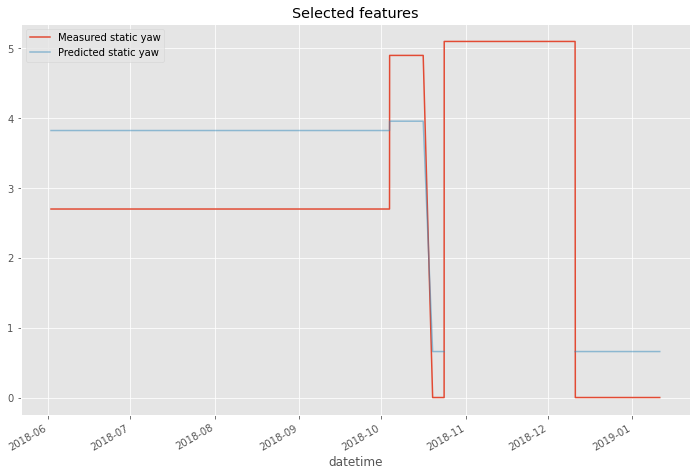

In [17]:
df_scaled = scale_df(df.copy())
df_scaled['y'] = df['y']
selected_features = ['wind speed', 'pitch angle', 'rotor speed']
models_file = 'trained_models_selected.pickle' 
with open(models_file, 'rb') as file:
    models_dict = pickle.load(file)
    
bin_feature = 'wind speed'
binned_data_dfs = []
for b in bin_masks:
    df_temp = df_scaled[b]
    binned_data_dfs.append(df_temp.copy())
    
fit_features = selected_features 
target_feature = ['active power']
    
evaluation_scores = {}
evaluation_preds = {}
static_misalignment_values1 = [x for i, x in enumerate(static_misalignment_values) if i != 4]
print(static_misalignment_values1)
for theta_s in tqdm(np.unique(static_misalignment_values1)):
    #print(f'Working on {theta_s}')
    evaluation_scores[str(theta_s)] = {}
    evaluation_preds[str(theta_s)] = {}
    for key, models in models_dict.items():
        mape_list = []
        evaluation_preds[str(theta_s)][key] = {}
        #print(f'evaluating with models trained on {key}')
        for bin_n, d in enumerate(binned_data_dfs):
            d = d[d['y'] == theta_s].copy()
            if d.shape[0] >= 100 and models[bin_n] is not None:
                test_preds = predict(d, models[bin_n], fit_features, target_feature)
                r_sq, mae, me, mape, mpe = score(d[target_feature].values, test_preds)
                mape_list.append(mae)
                evaluation_preds[str(theta_s)][key][str(bin_n)] = test_preds
            else:
                evaluation_preds[str(theta_s)][key][str(bin_n)] = None
        avg_mape = np.mean(mape_list)
        evaluation_scores[str(theta_s)][key] = avg_mape
print(evaluation_scores)

# estimate the angle using a weighted average with the frequency of each point
result = {}
for th_s in np.unique(static_misalignment_values1): 
    print(th_s)
    average_for_each_bin = []
    for bin_n, d in enumerate(binned_data_dfs):
        d = d[d['y'] == th_s].copy()
        if d.shape[0] <= 100 or test_preds is None:
            continue
            
        # label each point in one bin to the closest prediction by the models of each angle of the bin
        label_per_bin = np.zeros(d[target_feature].shape) - 1
        diffs_per_bin = np.zeros(d[target_feature].shape) + np.inf # used to hold the minimum diffs until now
        l_test = np.zeros(d[target_feature].shape) - 1
        scoring_metrics = {}
        test_diffs = []
        for key, bin_dict in evaluation_preds[str(th_s)].items():
            # these are the predictions if the trained model corresponding to "key" angle/ in bin bin_n
            test_preds = bin_dict[str(bin_n)]
            if d.shape[0] >= 100 and test_preds is not None:
                # calculate the differences between the actual and predicted values (residuals)
                (r_sq, mae, me, mape, mpe) = score(d[target_feature].values, test_preds)
                temp_diff = np.abs(test_preds-d[target_feature].values)
                test_diffs.append(temp_diff.ravel())
#                 # unncomment line below for histograms of the differences for each bin for each model
#                 plt.hist(temp_diff, label=key, bins = 20)
#                 plt.axvline(temp_diff.mean(), color='k', linestyle='dashed', linewidth=1, label=f'mean of {key} = {temp_diff.mean():.3}')
#                 plt.legend()
#                 plt.show()
                mask = (temp_diff <= diffs_per_bin) # mask to find the points with current difference lower than the minimum
                diffs_per_bin[mask] = temp_diff[mask]
                scoring_metrics[str(np.abs(float(key)))] = (r_sq, mae, me, mape, mpe) # store metrics 
                label_per_bin[mask] = np.abs(float(key)) # assign labels
            else:
                pass
        unique, counts = np.unique(label_per_bin, return_counts=True)
        print(f"For bin {bin_n} in the regions with ground truth angle {th_s}")
        print(f"The distribution of prediction labels for the interval is:")
        print(unique, counts, end='\n\n')
        # barplot  with the frequencies of each label
#         plt.bar(np.arange(unique.shape[0]), counts)
#         plt.xticks(np.arange(unique.shape[0]), labels=unique)
#         plt.show()
        # calculate weighted average for each bin
        if n_most_freq is not None:
            idx = counts.argsort()[::-1][:n_most_freq]
            unique = unique[idx]
            counts = counts[idx]
        res = np.average(unique, weights=counts)
        average_for_each_bin.append(res)
    print("The weighted average (by frequency) of this bin is:")
    print(average_for_each_bin)
    print(np.mean(average_for_each_bin))
    result[str(th_s)] = np.mean(average_for_each_bin)
    
df['y_pred'] = np.nan
for th_s in np.unique(static_misalignment_values1): 
    df['y_pred'][df['y']==th_s] = result[str(th_s)]

prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

target.plot(figsize=(12, 8), label = 'Measured static yaw')
prediction.plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()







[2.7, 2.7, 4.9, 0, 0]


  0%|          | 0/3 [00:00<?, ?it/s]

{'0.0': {'-6.7': 0.22545714431282138, '0.0': 0.11201864178292874, '4.8': 0.24009115673150566, '9.4': 0.26616130366223284}, '2.7': {'-6.7': 0.05429110090747741, '0.0': 0.1132540667235011, '4.8': 0.06676273656923748, '9.4': 0.09574431089077998}, '4.9': {'-6.7': 0.04562598533812596, '0.0': 0.13134072074304937, '4.8': 0.049349168727621955, '9.4': 0.05871010632675725}}
0.0
For bin 0 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  4.8 6.7] [4000    6   67]

For bin 1 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  6.7] [3549   65]

For bin 2 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  6.7] [3169   30]

For bin 3 in the regions with ground truth angle 0.0
The distribution of prediction labels for the interval is:
[0.  6.7] [2713   14]

For bin 4 in the regions with ground truth angle 0.0
The distribution of predict

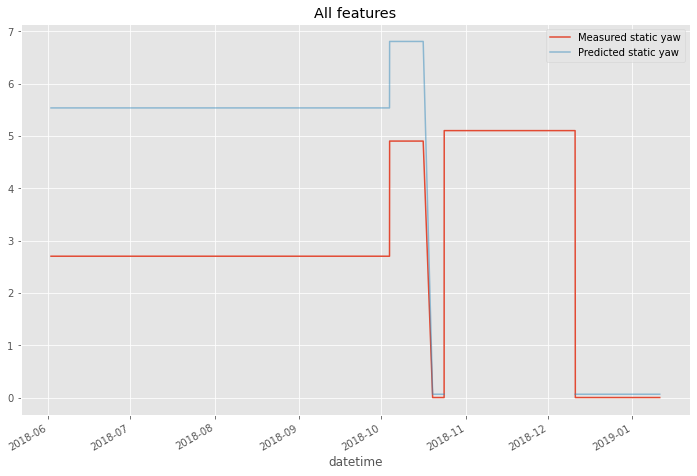

In [18]:
df_scaled = scale_df(df.copy())
df_scaled['y'] = df['y']
selected_features = ['wind speed', 'pitch angle', 'rotor speed']
models_file = 'trained_models_wind_speed.pickle' 
with open(models_file, 'rb') as file:
    models_dict = pickle.load(file)
    
bin_feature = 'wind speed'
binned_data_dfs = []
for b in bin_masks:
    df_temp = df_scaled[b]
    binned_data_dfs.append(df_temp.copy())
    
fit_features = selected_features 
fit_features = ['wind speed']
target_feature = ['active power']
    
evaluation_scores = {}
evaluation_preds = {}
static_misalignment_values1 = [x for i, x in enumerate(static_misalignment_values) if i != 4]
print(static_misalignment_values1)
for theta_s in tqdm(np.unique(static_misalignment_values1)):
    #print(f'Working on {theta_s}')
    evaluation_scores[str(theta_s)] = {}
    evaluation_preds[str(theta_s)] = {}
    for key, models in models_dict.items():
        mape_list = []
        evaluation_preds[str(theta_s)][key] = {}
        #print(f'evaluating with models trained on {key}')
        for bin_n, d in enumerate(binned_data_dfs):
            d = d[d['y'] == theta_s].copy()
            if d.shape[0] >= 100 and models[bin_n] is not None:
                test_preds = predict(d, models[bin_n], fit_features, target_feature)
                r_sq, mae, me, mape, mpe = score(d[target_feature].values, test_preds)
                mape_list.append(mae)
                evaluation_preds[str(theta_s)][key][str(bin_n)] = test_preds
            else:
                evaluation_preds[str(theta_s)][key][str(bin_n)] = None
        avg_mape = np.mean(mape_list)
        evaluation_scores[str(theta_s)][key] = avg_mape
print(evaluation_scores)

# estimate the angle using a weighted average with the frequency of each point
result = {}
for th_s in np.unique(static_misalignment_values1): 
    print(th_s)
    average_for_each_bin = []
    for bin_n, d in enumerate(binned_data_dfs):
        d = d[d['y'] == th_s].copy()
        if d.shape[0] <= 100 or test_preds is None:
            continue
            
        # label each point in one bin to the closest prediction by the models of each angle of the bin
        label_per_bin = np.zeros(d[target_feature].shape) - 1
        diffs_per_bin = np.zeros(d[target_feature].shape) + np.inf # used to hold the minimum diffs until now
        l_test = np.zeros(d[target_feature].shape) - 1
        scoring_metrics = {}
        test_diffs = []
        for key, bin_dict in evaluation_preds[str(th_s)].items():
            # these are the predictions if the trained model corresponding to "key" angle/ in bin bin_n
            test_preds = bin_dict[str(bin_n)]
            if d.shape[0] >= 100 and test_preds is not None:
                # calculate the differences between the actual and predicted values (residuals)
                (r_sq, mae, me, mape, mpe) = score(d[target_feature].values, test_preds)
                temp_diff = np.abs(test_preds-d[target_feature].values)
                test_diffs.append(temp_diff.ravel())
#                 # unncomment line below for histograms of the differences for each bin for each model
#                 plt.hist(temp_diff, label=key, bins = 20)
#                 plt.axvline(temp_diff.mean(), color='k', linestyle='dashed', linewidth=1, label=f'mean of {key} = {temp_diff.mean():.3}')
#                 plt.legend()
#                 plt.show()
                mask = (temp_diff <= diffs_per_bin) # mask to find the points with current difference lower than the minimum
                diffs_per_bin[mask] = temp_diff[mask]
                scoring_metrics[str(np.abs(float(key)))] = (r_sq, mae, me, mape, mpe) # store metrics 
                label_per_bin[mask] = np.abs(float(key)) # assign labels
            else:
                pass
        unique, counts = np.unique(label_per_bin, return_counts=True)
        print(f"For bin {bin_n} in the regions with ground truth angle {th_s}")
        print(f"The distribution of prediction labels for the interval is:")
        print(unique, counts, end='\n\n')
        # barplot  with the frequencies of each label
#         plt.bar(np.arange(unique.shape[0]), counts)
#         plt.xticks(np.arange(unique.shape[0]), labels=unique)
#         plt.show()
        # calculate weighted average for each bin
        if n_most_freq is not None:
            idx = np.argmax(counts)
            unique = unique[idx]
            counts = counts[idx]
        res = np.average(unique, weights=counts)
        average_for_each_bin.append(res)
    print("The weighted average (by frequency) of this bin is:")
    print(average_for_each_bin)
    print(np.mean(average_for_each_bin))
    result[str(th_s)] = np.mean(average_for_each_bin)
    
df['y_pred'] = np.nan
for th_s in np.unique(static_misalignment_values1): 
    df['y_pred'][df['y']==th_s] = result[str(th_s)]

prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

target.plot(figsize=(12, 8), label = 'Measured static yaw')
prediction.plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('All features')
plt.legend()
plt.show()





